# Data Analysis Cycle

<img src='./img/DataAnalysis_CycleTS0.png' width='800'>

<img src='./img/DataAnalysis_Cycle1.png' width='800'>

<img src='./img/DataAnalysis_CycleTS1.png' width='800'>

<img src='./img/DataAnalysis_CycleTS3.png' width='800'>

<img src='./img/DataAnalysis_CycleTS4.png' width='800'>

<img src='./img/DataAnalysis_CycleTS2.png' width='800'>

<img src='./img/DataAnalysis_CycleTS5.png' width='800'>

<img src='./img/DataAnalysis_Cycle4.png' width='800'>

<img src='./img/DataAnalysis_Cycle5.png' width='800'>

<img src='./img/DataAnalysis_Cycle6.png' width='800'>

<img src='./img/DataAnalysis_Cycle7.png' width='800'>

<img src='./img/DataAnalysis_Cycle8.png' width='800'>

<img src='./img/DataAnalysis_Cycle9.png' width='800'>


# **Import Library:** 분석에 사용할 모듈 설치

In [2]:
# !pip install --upgrade pip
# !python -m pip install --user --upgrade pip

In [4]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from tqdm import tqdm

# Modeling algorithms
# General
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Model selection
from sklearn.model_selection import train_test_split

# Evaluation metrics
from sklearn import metrics
# for regression
from sklearn.metrics import mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error

## 분석가 정의 함수

In [6]:
# 시계열 변수추출
## 날짜인식 및 빈도 설정만
def non_feature_engineering(df):
    df_nfe = df.copy()
    if 'datetime' in df_nfe.columns:
        df_nfe['datetime'] = pd.to_datetime(df_nfe['datetime'])
        df_nfe['DateTime'] = pd.to_datetime(df_nfe['datetime'])
    if df_nfe.index.dtype == 'int64':
        df_nfe.set_index('DateTime', inplace=True)
    df_nfe = df_nfe.asfreq('H', method='ffill')

    return df_nfe


## 날짜인식 및 빈도 설정을 포함한 모든 전처리
def feature_engineering(df):
    df_fe = df.copy()
    if 'datetime' in df_fe.columns:
        df_fe['datetime'] = pd.to_datetime(df_fe['datetime'])
        df_fe['DateTime'] = pd.to_datetime(df_fe['datetime'])

    if df_fe.index.dtype == 'int64':
        df_fe.set_index('DateTime', inplace=True)

    df_fe = df_fe.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(df_fe['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([df_fe, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in df_fe.columns:
        if 'count_seasonal' not in df_fe.columns:
            df_fe = pd.concat([df_fe, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = df_fe[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = df_fe[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in df_fe.columns:
        df_fe = pd.concat([df_fe, Y_count_Day], axis=1)
    if 'count_Week' not in df_fe.columns:
        df_fe = pd.concat([df_fe, Y_count_Week], axis=1)

    Y_diff = df_fe[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in df_fe.columns:
        df_fe = pd.concat([df_fe, Y_diff], axis=1)

#     df_fe['temp_group'] = pd.cut(df_fe['temp'], 10)
    df_fe['Year'] = df_fe.datetime.dt.year
    df_fe['Quater'] = df_fe.datetime.dt.quarter
    df_fe['Quater_ver2'] = df_fe['Quater'] + (df_fe.Year - df_fe.Year.min()) * 4
    df_fe['Month'] = df_fe.datetime.dt.month
    df_fe['Day'] = df_fe.datetime.dt.day
    df_fe['Hour'] = df_fe.datetime.dt.hour
    df_fe['DayofWeek'] = df_fe.datetime.dt.dayofweek

    df_fe['count_lag1'] = df_fe['count'].shift(1)
    df_fe['count_lag2'] = df_fe['count'].shift(2)
    df_fe['count_lag1'].fillna(method='bfill', inplace=True)
    df_fe['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in df_fe.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in df_fe.columns]:
            df_fe = pd.concat([df_fe, pd.get_dummies(df_fe['Quater'], prefix='Quater_Dummy', drop_first=True)], axis=1)
            del df_fe['Quater']
    
    return df_fe


# 데이터 분리
## cross sectional 데이터
def datasplit(df, Y_colname, test_size=0.2, random_state=123):
    X_colname = [x for x in df.columns if x not in Y_colname]
       
    X_train, X_test, Y_train, Y_test = train_test_split(df[X_colname], df[Y_colname],
                                                        test_size=test_size, random_state=random_state)
    print(X_train.shape, Y_train.shape)
    print(X_test.shape, Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test


## time series 데이터
def datasplit_ts(df, Y_colname, X_colname, criteria):
    df_train = df.loc[df.index < criteria,:]
    df_test = df.loc[df.index >= criteria,:]
    Y_train = df_train[Y_colname]
    X_train = df_train[X_colname]
    Y_test = df_test[Y_colname]
    X_test = df_test[X_colname]
    print('Train_size:', df_train.shape, 'Test_size:', df_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test


# 실제 Y와 예측치 시각화
def plot_prediction(Y_true_pred):
    plt.figure(figsize=(16, 8))
    plt.plot(Y_true_pred, linewidth=5, label=Y_true_pred.columns)
    plt.xticks(fontsize=25, rotation=0)
    plt.yticks(fontsize=25)
    plt.xlabel('Index', fontname='serif', fontsize=28)
    plt.legend(fontsize=20)
    plt.grid()
    plt.show()
    
    
# 검증 함수화
def evaluation_reg(Y_real, Y_pred):
    MAE = mean_absolute_error(Y_real, Y_pred)
    MSE = mean_squared_error(Y_real, Y_pred)
    MAPE = mean_absolute_percentage_error(Y_real, Y_pred)
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    
    return Score

# Train & Test 모두의 검증 함수화
def evaluation_reg_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te):
    Score_tr = evaluation_reg(Y_real_tr, Y_pred_tr)
    Score_te = evaluation_reg(Y_real_te, Y_pred_te)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']

    return Score_trte


# 에러 분석
def error_analysis_timeseries(X_Data, Y_Pred, Residual, graph_on=False):
    # Setting
    Resid = Residual.copy()
    if Resid.shape[0] >= 100:
        lag_max = 50
    else:
        lag_max = int(Resid.shape[0]/2)-1
        
    if graph_on == True:
        ##### 시각화
        # index를 별도 변수로 저장 
        Resid = Residual.copy()
        Resid['Index'] = Resid.reset_index().index
    
        # 잔차의 정규분포성 확인
        sns.distplot(Resid.iloc[:,[0]], norm_hist='True', fit=stats.norm)
        plt.show()

        # 잔차의 등분산성 확인
        # sns.lmplot(data=Resid, x='Index', y=Resid.columns[0],
        #            fit_reg=True, line_kws={'color': 'red'}, size=5, aspect=2, ci=99, sharey=True)
        sns.lmplot(data=Resid, x='Index', y=Resid.columns[0],
                   fit_reg=True, line_kws={'color': 'red'}, aspect=2, ci=99, sharey=True)
        plt.show()
        
        # 잔차의 자기상관성 확인
        sm.graphics.tsa.plot_acf(Resid.iloc[:,[0]], lags=lag_max, use_vlines=True)
        plt.ylabel('Correlation')
        plt.show()
        
        # 잔차의 편자기상관성 확인
        sm.graphics.tsa.plot_pacf(Resid.iloc[:,[0]], lags=lag_max, use_vlines=True)
        plt.ylabel('Correlation')
        plt.show()

    ##### 통계량
    # 정규분포
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Residual)], 
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # 등분산성
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Residual, X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], 
                                      columns=['Test Statistics', 'p-value', 'Alternative']).T
    
    # 자기상관
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Residual, lags=[10,lag_max]).iloc[:,0]),
                             pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Residual, lags=[10,lag_max]).iloc[:,1])], axis=1).T
    Autocorrelation.index = ['Test Statistics', 'p-value']
    Autocorrelation.columns = ['Autocorr(lag10)', 'Autocorr(lag50)']
    
    # 정상성
    # ADF
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity = pd.Series(sm.tsa.stattools.adfuller(Residual)[0:3], 
                             index=['Test Statistics', 'p-value', 'Used Lag'])
    for key, value in sm.tsa.stattools.adfuller(Resid.iloc[:,[0]])[4].items():
        Stationarity['Critical Value(%s)'%key] = value
    Stationarity_ADF = pd.DataFrame(Stationarity, columns=['Stationarity_ADF'])
    # KPSS
    # Null Hypothesis: The Time-series is stationalry
    Stationarity = pd.Series(sm.tsa.stattools.kpss(Residual)[0:3], 
                             index=['Test Statistics', 'p-value', 'Used Lag'])
    for key, value in sm.tsa.stattools.kpss(Resid.Error)[3].items():
        if key != '2.5%':
            Stationarity['Critical Value(%s)'%key] = value
    Stationarity_KPSS = pd.DataFrame(Stationarity, columns=['Stationarity_KPSS'])
    
    Error_Analysis = pd.concat([Normality, Heteroscedasticity, Autocorrelation,
                                Stationarity_ADF, Stationarity_KPSS], join='outer', axis=1)
    
    return Error_Analysis

# **Base Algorithm:** 분석결과

In [7]:
# # Colab에서 실행
# # 아래 코드 실행 후 파일 선택을 눌러서 
# # 'Bike_Sharing_Demand_Full.csv' 파일을 선택해주면 로딩 완료
# from google.colab import files
# files.upload()

# # 아래 코드 실행 시 'Bike_Sharing_Demand_Full.csv' 데이터 출력 가능
# import pandas as pd
# df = pd.read_csv('Bike_Sharing_Demand_Full.csv')
# df

## 전처리 미반영 분석결과

Train_size: (13128, 12) Test_size: (4416, 12)
X_train: (13128, 8) Y_train: (13128, 1)
X_test: (4416, 8) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.638
Model:                            OLS   Adj. R-squared (uncentered):              0.638
Method:                 Least Squares   F-statistic:                              2889.
Date:                Sat, 29 Apr 2023   Prob (F-statistic):                        0.00
Time:                        00:56:43   Log-Likelihood:                         -83421.
No. Observations:               13128   AIC:                                  1.669e+05
Df Residuals:                   13120   BIC:                                  1.669e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season         3.3659      1.286      2.618      0.009       0.846       5.886
holiday       -6.2896      7.466     -0.842      0.400     -20.924       8.345
workingday    10.3553      2.641      3.921      0.000       5.178      15.533
weather        7.1906      2.093      3.436      0.001       3.089      11.292
temp          -7.8544      1.222     -6.429      0.000     -10.249      -5.460
atemp         16.0695      1.095     14.676      0.000      13.923      18.216
humidity      -1.7353      0.063    -27.356      0.000      -1.860      -1.611
windspeed      2.2749      0.136     16.745      0.000       2.009       2.541
==============================================================================
Omnibus:                     2168.771   Durbin-Watson:                   0.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3942.747
Skew:                           1.050   Prob(JB):                         0.00
Kurtosis:                       4.672   Cond. No.                         450.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

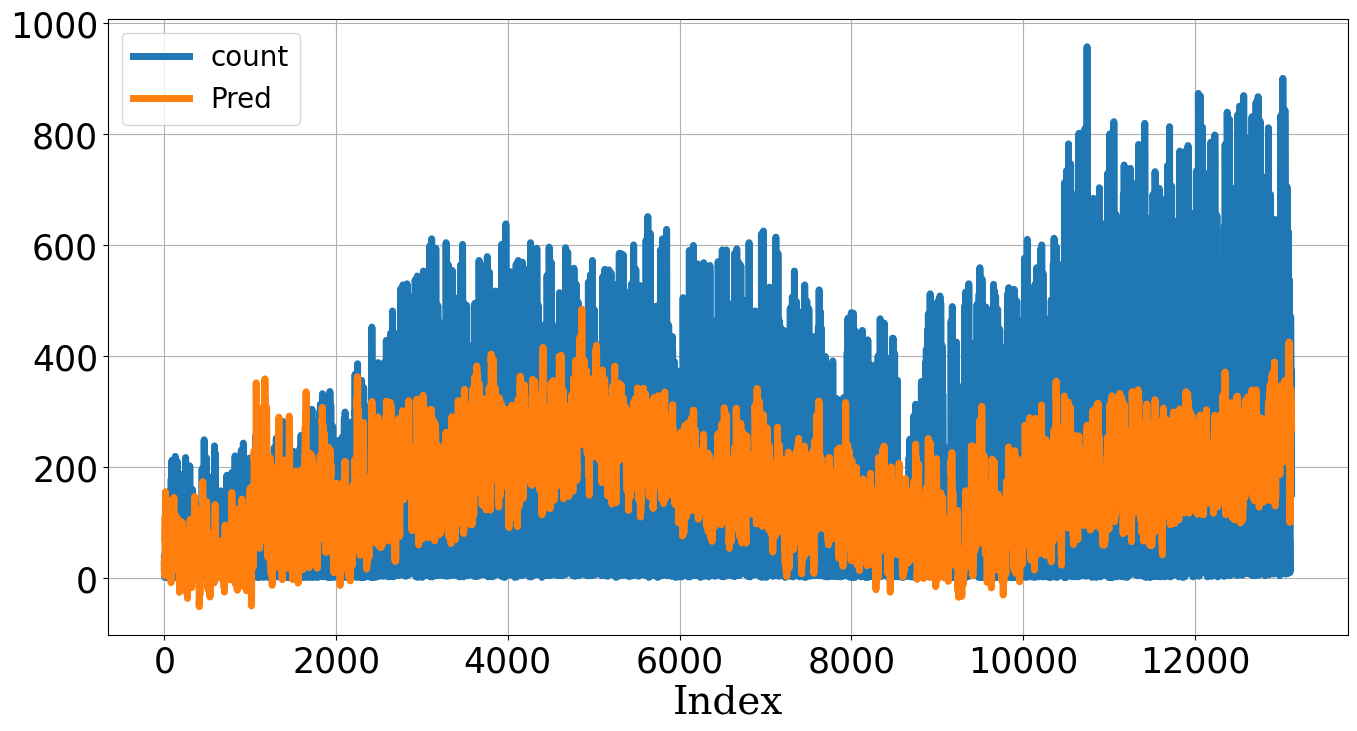

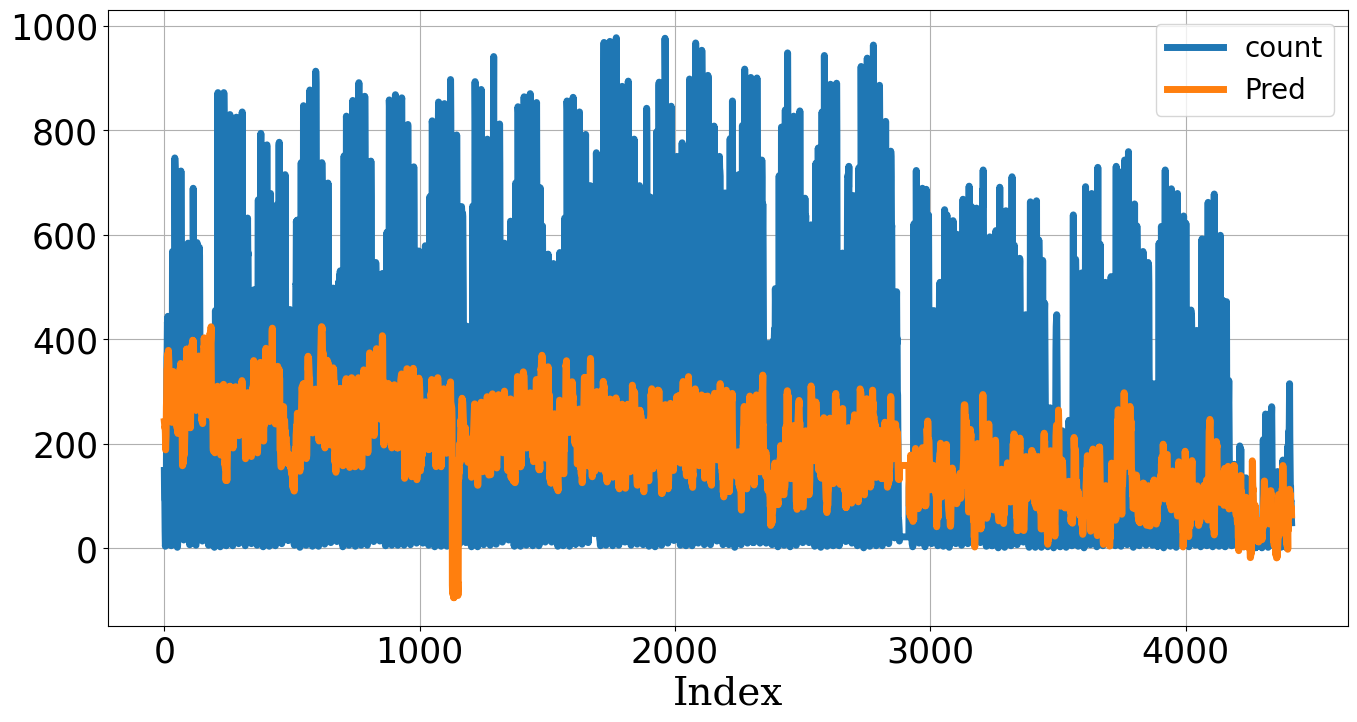

,MAE,MSE,MAPE
Train,103.09,"19,360.42",4.58
Test,150.03,"43,410.27",3.17


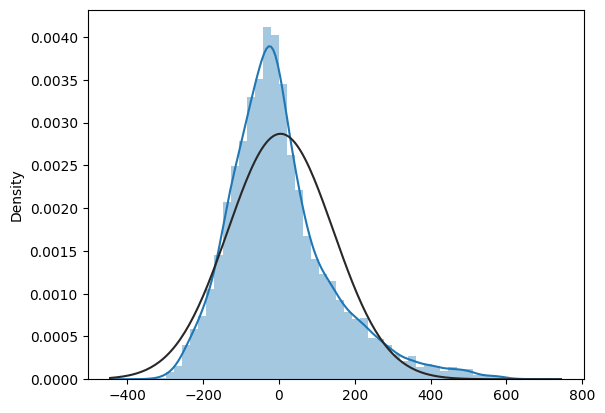

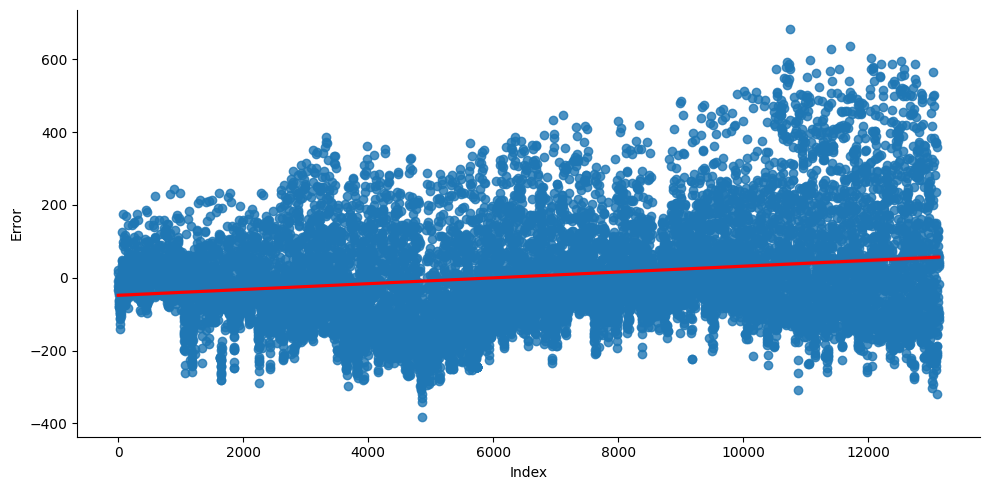

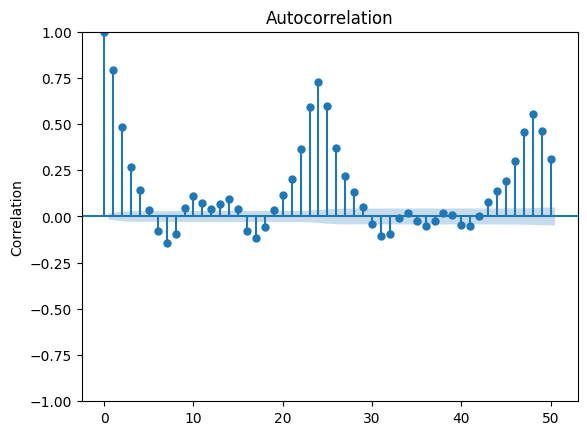

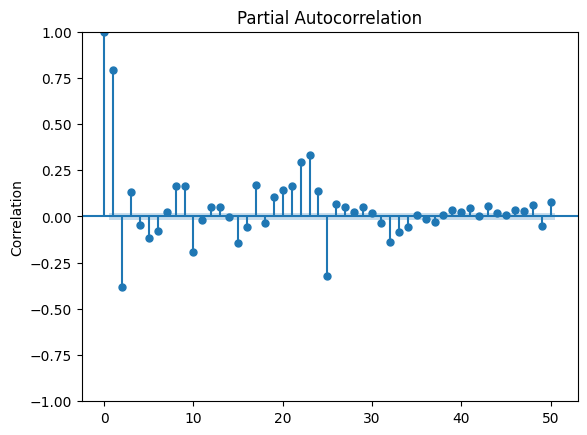

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.94,1.76,"13,138.03","48,485.56",-9.25,19.30
p-value,0.00,0.00,0.00,0.00,0.00,0.01
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,40.00,18.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


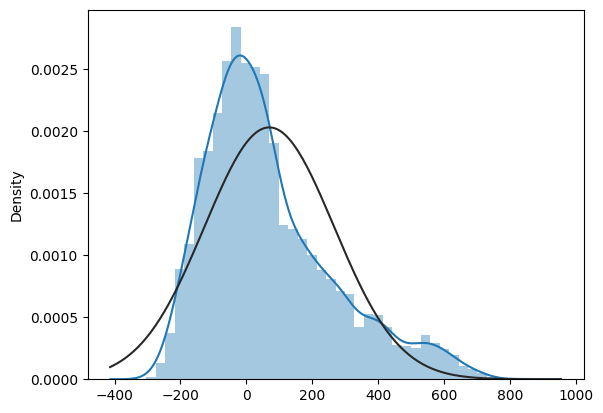

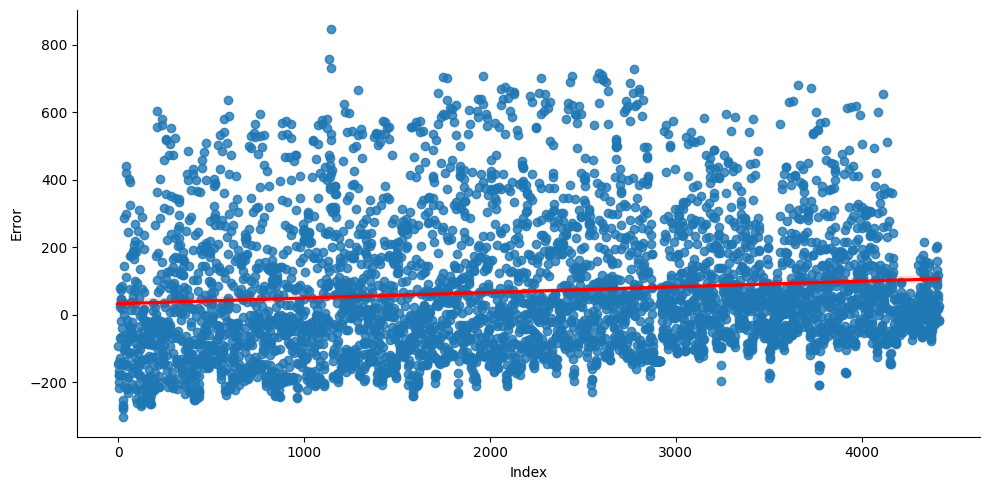

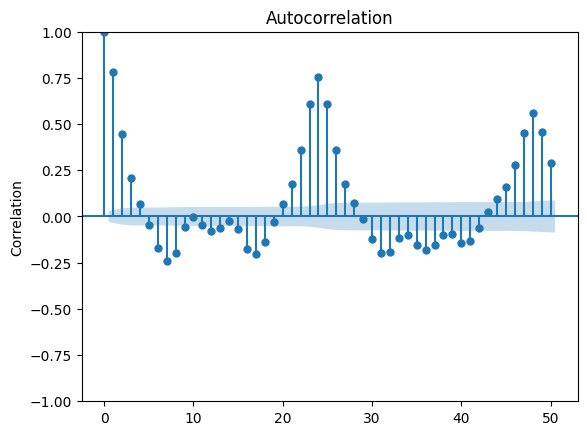

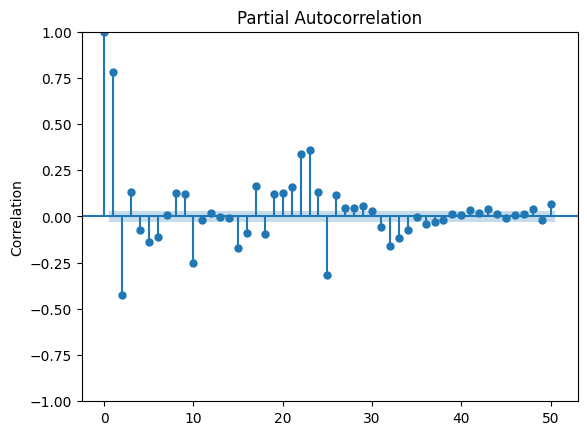

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.93,0.73,"4,400.21","17,427.07",-6.11,2.62
p-value,0.00,0.00,0.00,0.00,0.00,0.01
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,31.00,15.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


In [8]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = non_feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# Linear Regression
model_lr_Raw = sm.OLS(Y_train, X_train).fit()
display(model_lr_Raw.summary())

Y_trpred = pd.DataFrame(model_lr_Raw.predict(X_train), columns=['Pred'])
Y_tepred = pd.DataFrame(model_lr_Raw.predict(X_test), columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_Raw = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_Raw)

# 에러 분석
Resid_tr = Y_train - Y_trpred.values
Resid_tr.columns = ['Error']
Resid_te = Y_test - Y_tepred.values
Resid_te.columns = ['Error']

Error_tr = error_analysis_timeseries(X_train, Y_trpred, Resid_tr, graph_on=True)
display(Error_tr)
Error_te = error_analysis_timeseries(X_test, Y_tepred, Resid_te, graph_on=True)
display(Error_te)

## 전처리 반영 분석결과

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.362e+08
Date:                Sat, 29 Apr 2023   Prob (F-statistic):               0.00
Time:                        00:57:25   Log-Likelihood:                 1906.2
No. Observations:               13128   AIC:                            -3764.
Df Residuals:                   13104   BIC:                            -3585.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season            -0.0005      0.004     -0.129      0.897      -0.009       0.008
holiday            0.0083      0.014      0.612      0.540      -0.018       0.035
workingday         0.0079      0.007      1.184      0.236      -0.005       0.021
weather            0.0042      0.003      1.232      0.218      -0.003       0.011
temp               0.0022      0.002      1.075      0.282      -0.002       0.006
atemp             -0.0025      0.002     -1.347      0.178      -0.006       0.001
humidity          -0.0001      0.000     -0.845      0.398      -0.000       0.000
windspeed          0.0003      0.000      1.062      0.288      -0.000       0.001
count_trend     9.161e-05   8.57e-05      1.069      0.285   -7.64e-05       0.000
count_seasonal  1.984e-05   2.56e-05      0.775      0.438   -3.03e-05       7e-05
count_Day       4.177e-05   8.36e-05      0.500      0.617      -0.000       0.000
count_Week     -4.345e-05   9.61e-05     -0.452      0.651      -0.000       0.000
count_diff         1.0000    2.9e-05   3.45e+04      0.000       1.000       1.000
Year           -1.547e-05   7.97e-06     -1.939      0.052   -3.11e-05    1.66e-07
Quater_ver2        0.0004      0.002      0.180      0.857      -0.004       0.005
Month              0.0026      0.002      1.051      0.293      -0.002       0.007
Day                0.0004      0.000      1.728      0.084   -4.91e-05       0.001
Hour               0.0006      0.000      1.538      0.124      -0.000       0.001
DayofWeek          0.0003      0.002      0.224      0.823      -0.003       0.003
count_lag1         1.0000    2.7e-05    3.7e+04      0.000       1.000       1.000
count_lag2     -1.926e-05   2.59e-05     -0.744      0.457      -7e-05    3.15e-05
Quater_Dummy_2    -0.0010      0.009     -0.115      0.909      -0.019       0.017
Quater_Dummy_3    -0.0037      0.017     -0.220      0.826      -0.037       0.030
Quater_Dummy_4    -0.0132      0.026     -0.512      0.609      -0.064       0.037
==============================================================================
Omnibus:                    54426.083   Durbin-Watson:                   1.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      93552024983.828
Skew:                        -114.255   Prob(JB):                         0.00
Kurtosis:                   13078.751   Cond. No.                     3.49e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

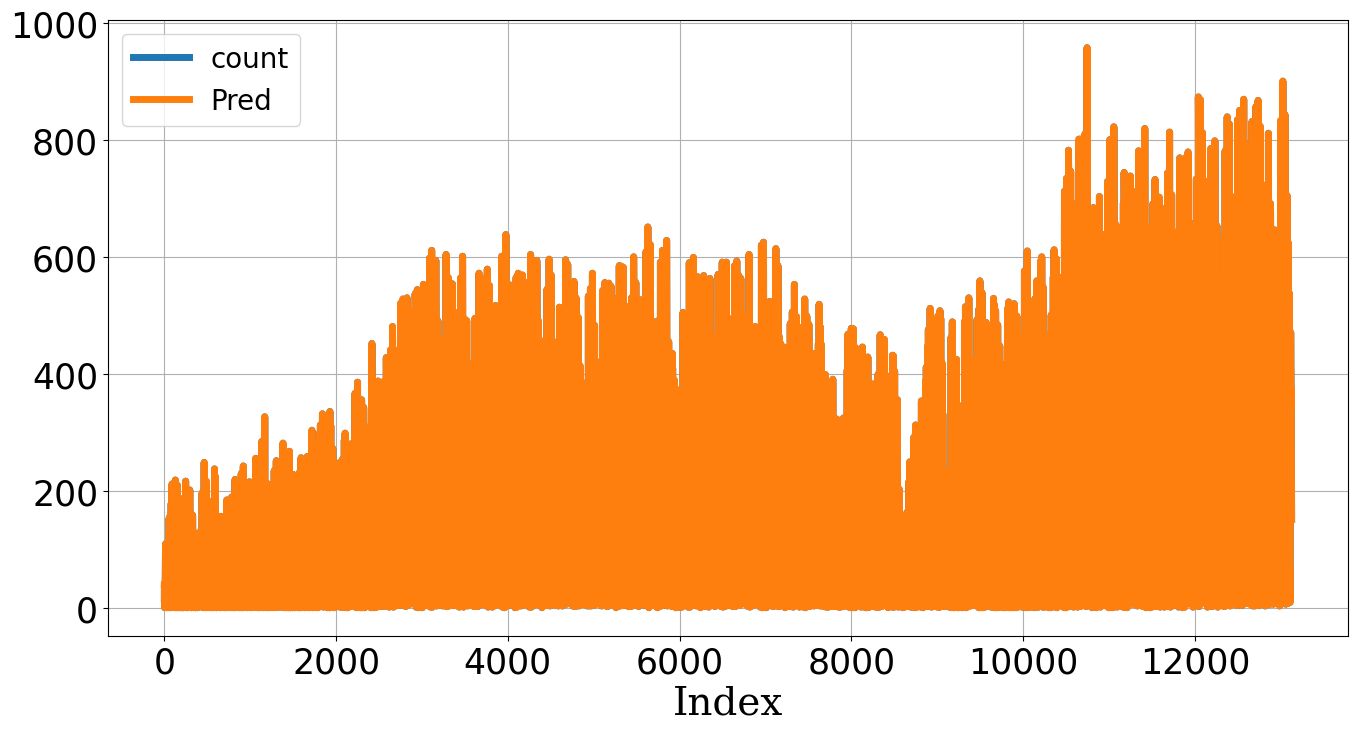

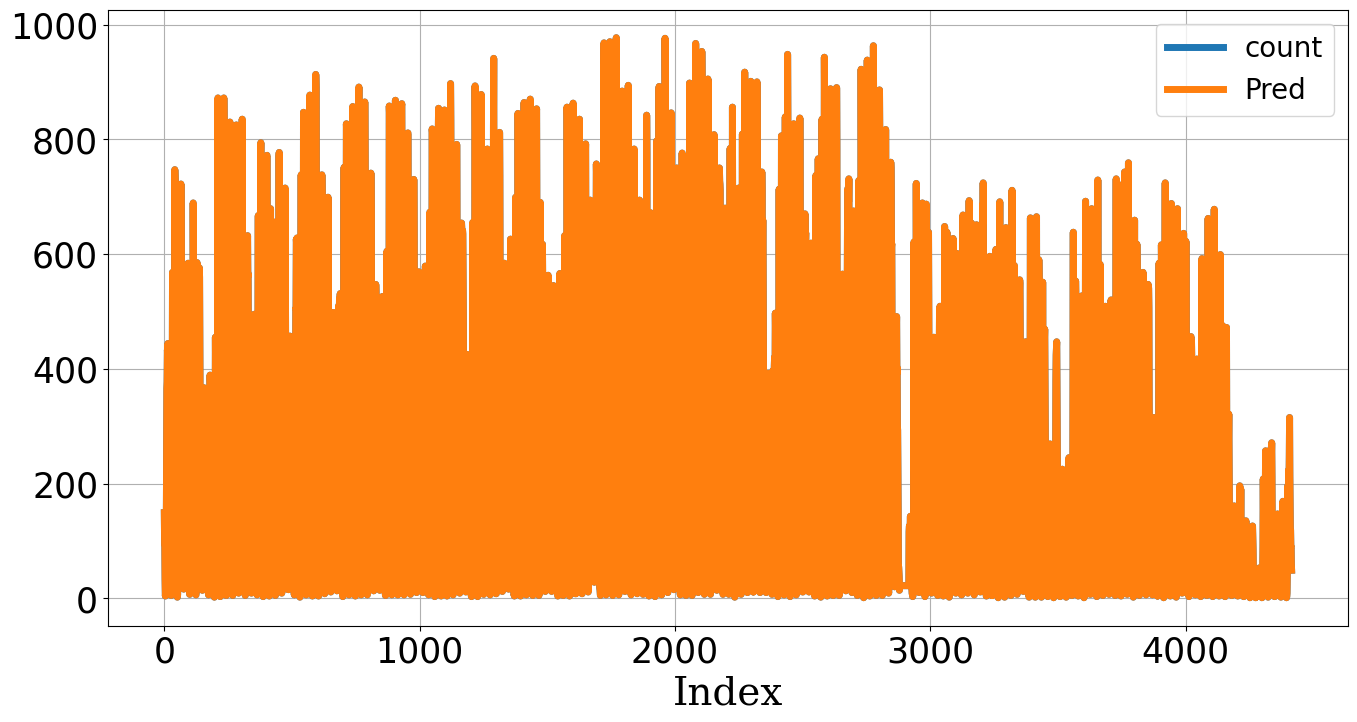

,MAE,MSE,MAPE
Train,0.01,0.04,0.00
Test,0.01,0.00,0.00


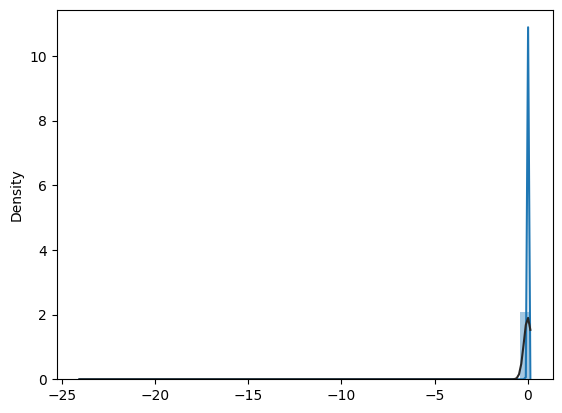

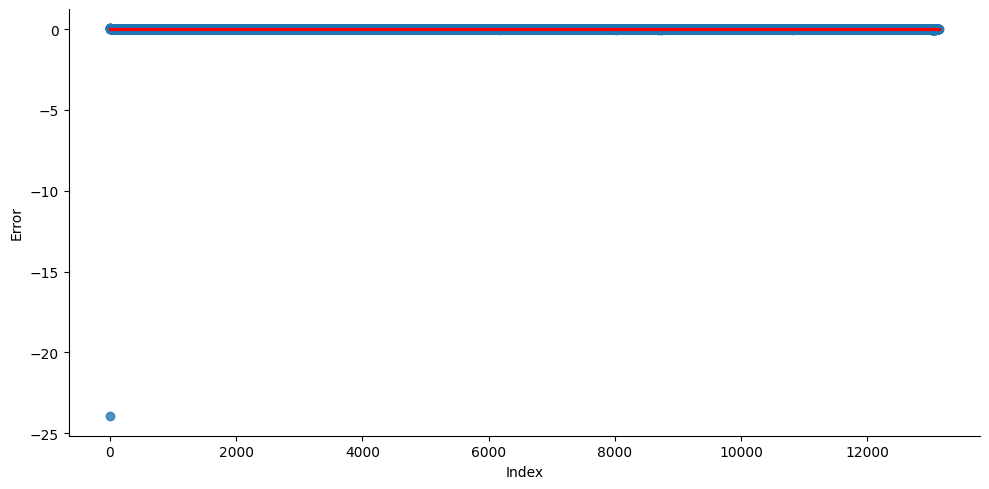

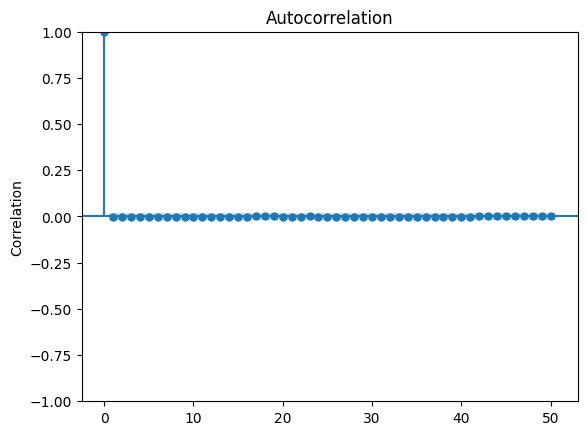

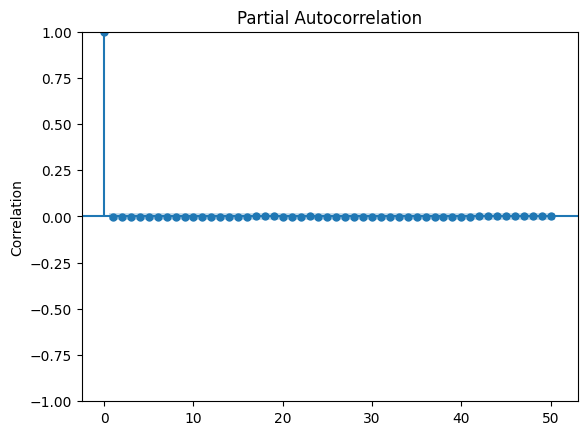

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.01,0.00,0.03,0.10,-9.98,0.09
p-value,0.00,0.00,1.00,1.00,0.00,0.10
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,41.00,2.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


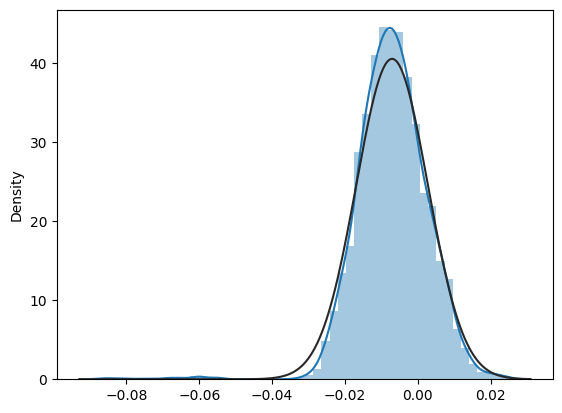

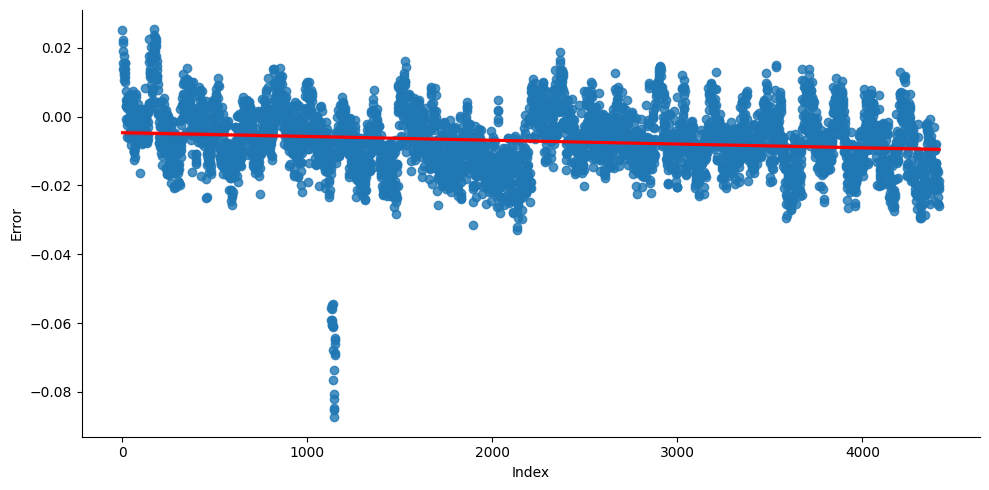

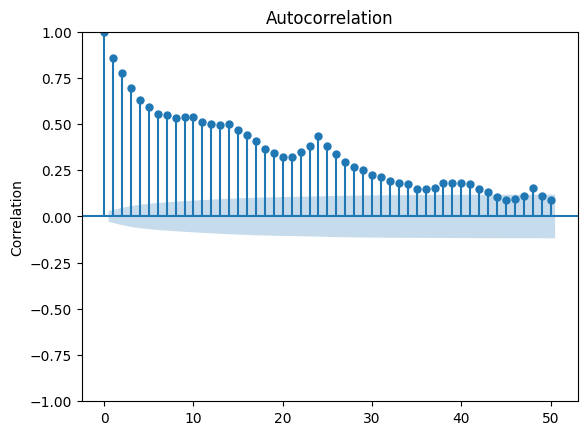

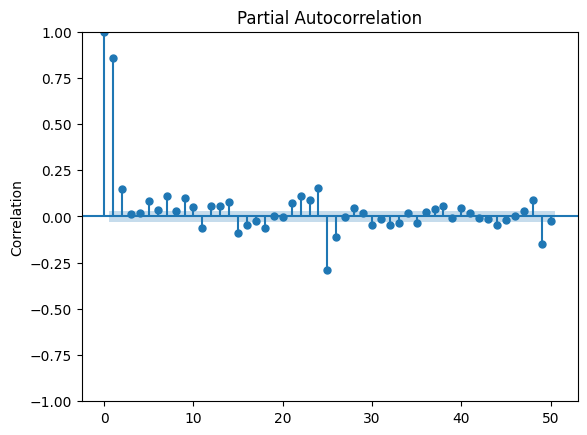

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.93,0.84,"17,815.72","33,403.03",-8.08,0.51
p-value,0.00,0.00,0.00,0.00,0.00,0.04
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,31.00,38.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


In [9]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# Linear Regression
model_lr = sm.OLS(Y_train, X_train).fit()
display(model_lr.summary())

Y_trpred = pd.DataFrame(model_lr.predict(X_train), columns=['Pred'])
Y_tepred = pd.DataFrame(model_lr.predict(X_test), columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_FEHalf = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_FEHalf)

# 에러 분석
Resid_tr = Y_train - Y_trpred.values
Resid_tr.columns = ['Error']
Resid_te = Y_test - Y_tepred.values
Resid_te.columns = ['Error']

Error_tr = error_analysis_timeseries(X_train, Y_trpred, Resid_tr, graph_on=True)
display(Error_tr)
Error_te = error_analysis_timeseries(X_test, Y_tepred, Resid_te, graph_on=True)
display(Error_te)

In [10]:
# 검증 성능이 너무 정확하다?
Score_FEHalf

,MAE,MSE,MAPE
Train,0.01,0.04,0.00
Test,0.01,0.00,0.00


# **Preprocessing Update:** 시계열 전처리 업데이트

## 시간현실 반영(Reality)

**"미래의 시간패턴을 `미리 반영하는건 비현실적`, 이는 `과적합(Overfitting)` 유발"**

- 데이터 전처리시, `데이터 분리 후 패턴을 추출`하여 해결

<img src='./img/DataAnalysis_CycleTS3.png' width='800'>

<img src='./img/DataAnalysis_CycleTS4.png' width='800'>

In [11]:
# Test 기간의 시계열 데이터를 알 수 있을까?
# 1) 과거의 시계열 패턴이 미래에 반복될 것이라 가정할 순 있지만 알순 없음!
# 2-1) 가장 좋은 방법은 미래 시점이 도래할 때까지 기다려서 Train 업데이트 후 Test 예측!
# 2-2) 그렇지 않으면 미래 시점을 하나씩 예측 후 예측값 자체를 Train에 반영하여 Test 예측!

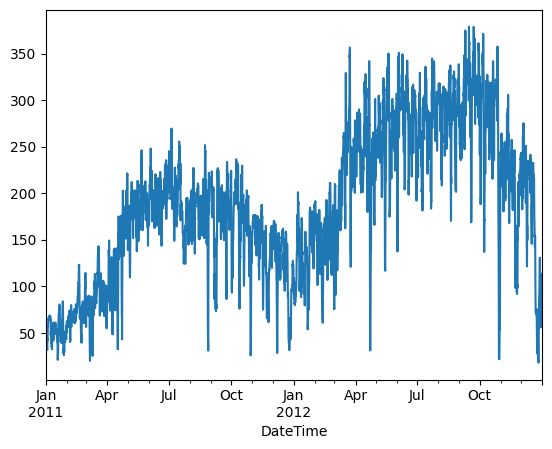

In [12]:
# 종속변수 시계열 추세 전체 확인
df_fe['count_trend'].plot()
plt.show()

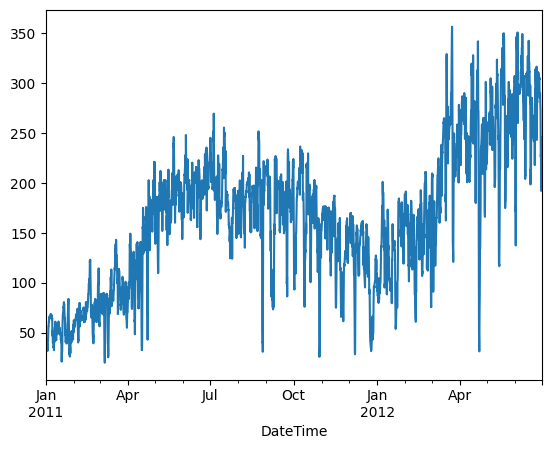

In [13]:
# 종속변수 시계열 추세 Train 확인
X_train['count_trend'].plot()
plt.show()

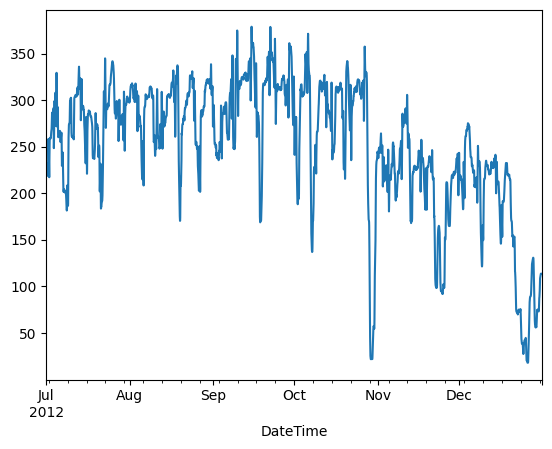

In [14]:
# 종속변수 시계열 추세 Test 확인
X_test['count_trend'].plot()
plt.show()

In [16]:
# 가정1) 2011년 7월~12월 추세가 2012년 7월~12월에도 나타날 수 있다
# 가정2) 2011년 1월~12월 추세가 2012년 1월~12월에도 나타날 수 있다 

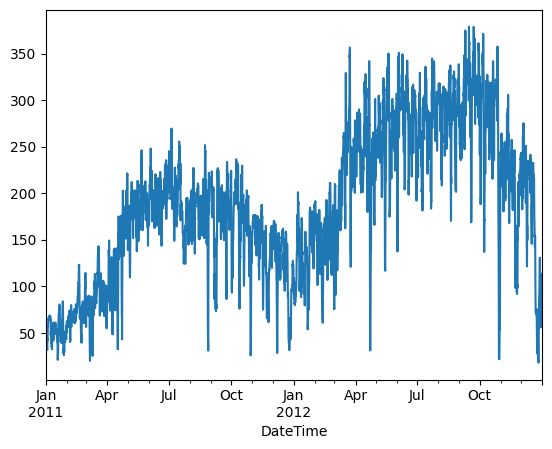

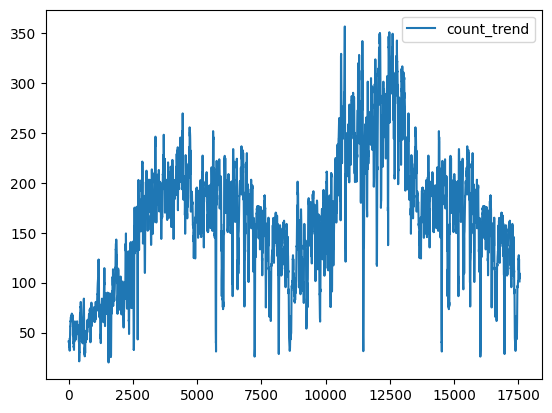

In [17]:
# 가정1의 경우로 데이터 결합시 종속변수 시계열 추세 전체 확인
df_fe['count_trend'].plot()
plt.show()
pd.concat([X_train['count_trend'],
           X_train.loc['2011-07-01':'2011-12-31', 'count_trend']],
           axis=0).reset_index().iloc[:,1:].plot()
plt.show()

In [18]:
# 가정2의 경우 추가적인 분석이 요구될 수 있음
len(df_fe.loc['2012-01-01':'2012-12-31', 'count_trend'])

8784

In [19]:
len(df_fe.loc['2011-01-01':'2011-12-31', 'count_trend'])

8760

In [ ]:
# 2월 29일이 12년에는 존재하지만 11년에는 존재하지 않음